### The following code accompanies the article
## "Eruptions in the attention economy: tracking volcanic eruptions and public engagement through multilingual social media analysis" ##

by Jamie I. Farquharson

ORCiD: 0000-0003-4933-2607

Institute for Research Administration, Niigata University, Ikarashi 2-8050, Nishi-ku, Niigata, 950-2181, Japan.

jfarquharson@gs.niigata-u.ac.jp

In [1]:
'''Import packages'''
import glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates
from matplotlib import patheffects
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
from matplotlib.ticker import FuncFormatter
from collections import Counter
from scipy.cluster.hierarchy import linkage, leaves_list, optimal_leaf_ordering, dendrogram
from scipy.spatial.distance import euclidean, cosine
from scipy.signal import find_peaks
from itertools import combinations
import string as STRING
import colorcet as cc
import ruptures as rpt
import numpy as np
import datetime as datetime
from datetime import timedelta
from scipy.stats import mannwhitneyu, ttest_ind
from scipy.ndimage import gaussian_filter1d
# import json
import warnings
warnings.filterwarnings('ignore')
import cld3
from IPython.display import HTML
from pathlib import Path
from tqdm import tqdm 
import seaborn as sns

print("All packages imported")

All packages imported


In [2]:
plt.rc('font', family='Helvetica')
mpl.rcParams.update({'font.size': 7})
plt.rc('text', usetex=False)

cmap = ListedColormap(cc.fire)
cmap_r = list(reversed(cc.fire))

buffer = [patheffects.withStroke(linewidth=.85, foreground="w")]

In [3]:
''' Various helper functions '''
def string_rearranger(string):
    '''
    Re-orders multi-part names (for example, "Fournaise, Piton de la" becomes "Piton de la Fournaise")
    '''
    old_string = string
    if ', ' in old_string:
        new_string = old_string.rpartition(', ')[2] +' '+ old_string.rpartition(', ')[0]
    else:
        new_string = old_string
    return new_string

def mm2inch(*tupl):
    ''' Function converts mm input to inches (for plotting figures the correct size) '''
    if isinstance(tupl[0], tuple):
        return tuple(k*0.0393701 for k in tupl[0])
    else:
        return tuple(k*0.0393701 for k in tupl)


def count_files_in_directory(directory):
    ''' Read the number of files in a directory '''
    return len(list(Path(directory).rglob('*.*')))


def count_lines_in_directory(directory):
    ''' Count the number of lines in a file '''
    total_lines = 0
    for file_path in Path(directory).rglob('*.*'):
        with file_path.open('r', encoding='utf-8', errors='ignore') as f:
            total_lines += sum(1 for line in f)
    return total_lines

''' Define dictionary of alternative fonts for printing non-Latin characters '''
fonts_dict = {
   'zh': 'Hiragino Sans GB',
'th': 'Ayuthaya',
'ja': 'Hiragino Sans GB',
'ko': 'AppleGothic',
'am': 'Kefa' ,
}
def alt_font(lan):
    ''' Selects font based on language '''
    if lan in fonts_dict.keys():
        new_font  = fonts_dict[lan]
    else:
        new_font = 'monospace'
    return new_font

def add_patch(ax, position, size, color, linewidth=0.85):
    '''Add patches to axis '''
    patch = patches.Rectangle(
        position,          # lower-left corner (fraction of axes width/height)
        size[0],           # width (fraction of axes width)
        size[1],           # height (fraction of axes height)
        linewidth=linewidth,
        edgecolor=color,
        facecolor='none',
        transform=ax.transAxes,  # Use axes fraction for positioning
        clip_on=False
    )
    ax.add_patch(patch)
    
def positive_tick_formatter(x, pos):
    '''Format all ticks as positive (for mirror plots)'''
    return f'{abs(x):.0f}'  

In [5]:
# '''
# workdir should be the path to the working directory, containing folders of crawled JSON data.
# '''
# workdir =  "../../../Desktop/twitter/twitter_search/"
# tweet_strings = glob.glob(workdir+"*/")
# tweet_strings = [x[x.find("_search/")+8::] for x in tweet_strings]
# key_list = [x[0:-1] for x in tweet_strings]
# with open("keys.txt", "w") as f: #saving keys to file
#     f.write(str(list(key_list)))

''' Full list of keywords corresponding to dataset folders [to be made available]'''
key_list = ['vulcano',
 'กิจกรรมภูเขาไฟ',
 'النشاط',
 'vulkaan',
 'yanardağ',
 'aktiviti',
 'вулканическая',
 'vulcânico',
 '火山活动',
 'vulkaanuitbarsting',
 'activité',
 'atividade',
 'Papers',
 '火山噴火',
 '火山活動',
 'volkaniese',
 'Eruzione',
 'vulcanico',
 'вулканический',
 'ภูเขาไฟ',
 '火山爆发',
 'извержение',
 'بركان',
 'volkan',
 'ภูเขาไฟระเบิด',
 'volkeno',
 'volcán',
 'vulkanische',
 'erupção',
 'вулкан',
 '화산의',
 'เกี่ยวกับภูเขาไฟ',
 'eldgos',
 'vulcão',
 'eldfjall',
 'volcanic',
 'volcánico',
 'vulkanausbruch',
 'بركاني',
 'eldvirkni',
 'éruption',
 'የእሳተ',
 'aktivitas',
 'vulkanisch',
 'volkanik',
 'vulkan',
 'volcanique',
 'erupsi',
 'እሳተ',
 'Actividad',
 'volcan',
 'gunung',
 '火山',
 '화산',
 'انفجار',
 'volcano',
 'letusan',
 'erupción',
 'attività',
 'vulkanik',
 'vulkaniese']

In [6]:
# All (full) strings considered in this study

eruption_strings = [
'volcanic eruption',
'火山噴火',
'erupción volcánica',
'letusan gunung berapi',
'erupção vulcânica',
'ثوران بركاني', 
'éruption volcanique',
'volkanik patlama',
'ภูเขาไฟระเบิด',
'화산 분출',
'火山爆发',
'erupsi vulkanik',
'vulkanausbruch',
'vulkaanuitbarsting',
'eldgos',
'извержение вулкана',
'Eruzione vulcanica',
'የእሳተ ገሞራ ፍንዳታ',
]


# Define list of (abbreviated) strings

string_list =[x for x in key_list if x in [(y.split()[0] or y.split()[1]) for y in eruption_strings]]
string_list.append('بركاني')

# Dict of full strings and abbreviations
abbr_dict = {'vulkaanuitbarsting':'vulkaanuitbarsting',
                 '火山噴火':'火山噴火',
                 'Eruzione':'Eruzione vulcanica',
                 '火山爆发':'火山爆发',
                 'извержение':'извержение вулкана',
                 'ภูเขาไฟระเบิด':'ภูเขาไฟระเบิด',
                 'erupção':'erupção vulcânica',
                 'eldgos':'eldgos',
                 'volcanic':'volcanic eruption',
                 'vulkanausbruch':'vulkanausbruch',
                 'éruption':'éruption volcanique',
                 'የእሳተ':'የእሳተ ገሞራ ፍንዳታ', 
                 'volkanik':'volkanik patlama',
                 'erupsi':'erupsi vulkanik',
                 '화산':'화산 분출',
                 'letusan':'letusan gunung berapi',
                 'erupción':'erupción volcánica',
                 'بركاني':'ثوران بركاني',
    }

string_dict = {value: key for key, value in abbr_dict.items()}

''' Convert from abbreviation to string '''
def abbr2string(abbr):
    return abbr_dict[abbr]

''' Convert from string to abbreviation '''
def string2abbr(string):
    return string_dict[string]

In [6]:
# for tweet_string in string_list:
#     directory_path = workdir+tweet_string
#     number_of_files = count_files_in_directory(directory_path)
#     print(f"Number of files in {tweet_string} directory: {number_of_files}")


Number of files in vulkaanuitbarsting directory: 828
Number of files in 火山噴火 directory: 516
Number of files in Eruzione directory: 691
Number of files in 火山爆发 directory: 989
Number of files in извержение directory: 965
Number of files in ภูเขาไฟระเบิด directory: 165
Number of files in erupção directory: 1005
Number of files in eldgos directory: 444
Number of files in volcanic directory: 1094
Number of files in vulkanausbruch directory: 1029
Number of files in éruption directory: 1065
Number of files in የእሳተ directory: 3
Number of files in volkanik directory: 1060
Number of files in erupsi directory: 637
Number of files in 화산 directory: 1061
Number of files in letusan directory: 1059
Number of files in erupción directory: 1085
Number of files in بركاني directory: 1079


In [7]:
# ''' Count total number of tweets used in study '''
# total_num_tweets = 0
# for tweet_string in string_list:
#     directory_path = workdir+tweet_string
#     total_lines = count_lines_in_directory(directory_path)
#     total_num_tweets += total_lines
#     print(f"Total number of lines in all {tweet_string} files: {total_lines}")
# print(f"Total number of Tweets: {total_num_tweets}")

Total number of lines in all vulkaanuitbarsting files: 15278
Total number of lines in all 火山噴火 files: 2151
Total number of lines in all Eruzione files: 7290
Total number of lines in all 火山爆发 files: 20401
Total number of lines in all извержение files: 28625
Total number of lines in all ภูเขาไฟระเบิด files: 27760
Total number of lines in all erupção files: 31541
Total number of lines in all eldgos files: 7068
Total number of lines in all volcanic files: 1493730
Total number of lines in all vulkanausbruch files: 44790
Total number of lines in all éruption files: 98600
Total number of lines in all የእሳተ files: 6
Total number of lines in all volkanik files: 91641
Total number of lines in all erupsi files: 42193
Total number of lines in all 화산 files: 4148790
Total number of lines in all letusan files: 73552
Total number of lines in all erupción files: 408219
Total number of lines in all بركاني files: 222643
Total number of Tweets: 6764278


In [9]:
''' Read in pre-compiled tweet count data from csv '''

tweet_counts_dict = {}
for st in tqdm(string_list, desc="Reading DataFrames"):
    tweet_counts = pd.read_csv(f'tweet_counts_{st}.csv')#, index_col=0)
    tweet_counts['date'] = tweet_counts[['date']].apply(pd.to_datetime)
    tweet_counts = tweet_counts.set_index('date')
#     tweet_counts['date'].values = tweet_counts.to_datetime(df['date'])
    tweet_counts_dict[st] = tweet_counts

Reading DataFrames: 100%|██████████| 18/18 [00:00<00:00, 82.49it/s]


In [10]:
'''
Accesses the most recent GVP volcanoes eruptions lists, saves them as csv files: "Holocene_volcanoes" and "Holocene_eruptions".
'''
!wget --no-check-certificate --output-document Holocene_eruptions.csv "https://webservices.volcano.si.edu/geoserver/GVP-VOTW/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=GVP_VOTW:Smithsonian_VOTW_Holocene_Eruptions&outputFormat=csv"
!wget --no-check-certificate --output-document Holocene_volcanoes.csv "https://webservices.volcano.si.edu/geoserver/GVP-VOTW/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=GVP_VOTW:Smithsonian_VOTW_Holocene_Volcanoes&outputFormat=csv"

'''
Read the downloaded csv file(s) into dataframe(s)
'''
volcano_list = pd.read_csv("Holocene_volcanoes.csv")
eruption_list = pd.read_csv("Holocene_eruptions.csv")

'''
Update volcano names to avoid duplicates
'''
temp_list = list(volcano_list.Volcano_Name)
duplicate_names = list(set([x for x in temp_list if temp_list.count(x) > 1]))
duplicate_numbers = []
for j in volcano_list.index:
    if volcano_list.Volcano_Name[j] in duplicate_names:
        volcano_list.Volcano_Name[j] = volcano_list.Volcano_Name[j]+' ' + str(volcano_list.Volcano_Number[j])
        duplicate_numbers.append(volcano_list.Volcano_Number[j])
len(set(duplicate_numbers))
for j in eruption_list.index:
    if eruption_list.Volcano_Number[j] in duplicate_numbers:
        eruption_list.Volcano_Name[j] = eruption_list.Volcano_Name[j]+' ' + str(eruption_list.Volcano_Number[j])

volcanoes = list(set(eruption_list.Volcano_Name)) ## {
print('{} volcano entries found, with a total of {} eruptions.\n{} distinct volcanoes identified.\n{} duplicate names:\n{}'.format(
    len(volcano_list),len(eruption_list),len(volcanoes), len(duplicate_names), duplicate_names))                           

--2025-03-11 17:13:00--  https://webservices.volcano.si.edu/geoserver/GVP-VOTW/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=GVP_VOTW:Smithsonian_VOTW_Holocene_Eruptions&outputFormat=csv
Resolving webservices.volcano.si.edu (webservices.volcano.si.edu)... 160.111.244.27
Connecting to webservices.volcano.si.edu (webservices.volcano.si.edu)|160.111.244.27|:443... connected.
HTTP request sent, awaiting response... 200 
Length: unspecified [text/csv]
Saving to: ‘Holocene_eruptions.csv’

Holocene_eruptions.     [             <=>    ]   2.07M   589KB/s    in 4.1s    

2025-03-11 17:13:05 (512 KB/s) - ‘Holocene_eruptions.csv’ saved [2167619]

--2025-03-11 17:13:05--  https://webservices.volcano.si.edu/geoserver/GVP-VOTW/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=GVP_VOTW:Smithsonian_VOTW_Holocene_Volcanoes&outputFormat=csv
Resolving webservices.volcano.si.edu (webservices.volcano.si.edu)... 160.111.244.27
Connecting to webservices.volcano.si.edu (webservices.volcano

In [11]:
''' We only need events from 2019 onwards '''
merged_list = pd.merge(eruption_list, volcano_list, on='Volcano_Number')
eruption_list['eruption_dates'] = pd.to_datetime(eruption_list.StartDateYear*10000
                                        +eruption_list.StartDateMonth*100
                                        +eruption_list.StartDateDay,
                                        format = '%Y%m%d', errors='ignore')
eruption_list = eruption_list.sort_values('eruption_dates', axis = 0)
eruption_list=eruption_list[eruption_list.StartDateYear>=2019]
eruption_list['date_objects'] = pd.to_datetime(eruption_list.eruption_dates.values, format='%Y%m%d')

In [12]:
# Create a data table 
table_df =pd.DataFrame()
table_df["String"] = [abbr2string(k) for k in tweet_counts_dict.keys()]
table_df["Total"] = [sum(tweet_counts_dict[k]['id']) for k in tweet_counts_dict.keys()]
table_df["Max"] = [max(tweet_counts_dict[k]['id']) for k in tweet_counts_dict.keys()]

table_df = table_df.sort_values('Total')#.reset_index()


HTML(table_df.to_html(index=False))

String,Total,Max
የእሳተ ገሞራ ፍንዳታ,6,2
erupsi vulkanik,165,16
火山噴火,1006,163
화산 분출,2918,832
ثوران بركاني,3702,283
ภูเขาไฟระเบิด,4319,2253
Eruzione vulcanica,4394,316
eldgos,4615,1331
vulkaanuitbarsting,10220,1055
火山爆发,11639,1153


In [13]:
''' Count the months with the most tweets (daily/monthly) across all languages'''

# initialise dicts
top_sum_months_dict = {}
top_max_months_dict = {}

# initialize Counters 
sum_month_counter = Counter()
max_month_counter = Counter()

N = 5 # Top N only

for ix, st in enumerate((string2abbr(x) for x in table_df["String"].values)):
#     counts = tweet_counts_dict[st]
    
    c = pd.DataFrame(tweet_counts_dict[st])
    c.index = pd.to_datetime(c.index)  # Ensure the index is a DatetimeIndex if not already
    monthly_summary = c.resample('M').agg({'id': ['sum', 'max']})
    monthly_summary.columns = ['id_sum', 'id_max'] 
    
    print('\n#####################\n{}\n#####################'.format(st))
    
    # Get months w/ top N sums
    top_sums = monthly_summary['id_sum'].nlargest(N)
    print("Top N months by sum:")
    print(top_sums)
    
    # Save to dict
    top_sum_months_dict[st] = top_sums.index
    
    # Update Counter 
    sum_month_counter.update(top_sums.index.strftime('%Y-%m'))

    # Get months w/ top N max values
    top_maxes = monthly_summary['id_max'].nlargest(N)
    print("\nTop N months by max:")
    print(top_maxes)
    
    # Save to dict
    top_max_months_dict[st] = top_maxes.index
    
    # Update Counter for max
    max_month_counter.update(top_maxes.index.strftime('%Y-%m'))

    
print("\nSum Month Counter:")
print(sum_month_counter)

print("\nMax Month Counter:")
print(max_month_counter)



#####################
የእሳተ
#####################
Top N months by sum:
date
2021-05-31 00:00:00+00:00    4
2019-12-31 00:00:00+00:00    2
2020-01-31 00:00:00+00:00    0
2020-02-29 00:00:00+00:00    0
2020-03-31 00:00:00+00:00    0
Name: id_sum, dtype: int64

Top N months by max:
date
2019-12-31 00:00:00+00:00    2
2021-05-31 00:00:00+00:00    2
2020-01-31 00:00:00+00:00    0
2020-02-29 00:00:00+00:00    0
2020-03-31 00:00:00+00:00    0
Name: id_max, dtype: int64

#####################
erupsi
#####################
Top N months by sum:
date
2020-08-31 00:00:00+00:00    32
2022-01-31 00:00:00+00:00    23
2019-10-31 00:00:00+00:00    22
2020-09-30 00:00:00+00:00    12
2021-03-31 00:00:00+00:00    10
Name: id_sum, dtype: int64

Top N months by max:
date
2020-08-31 00:00:00+00:00    16
2019-10-31 00:00:00+00:00    11
2020-09-30 00:00:00+00:00    11
2021-03-31 00:00:00+00:00    10
2022-01-31 00:00:00+00:00     7
Name: id_max, dtype: int64

#####################
火山噴火
#####################
Top 

In [14]:
''' Tunable scaling parameters for defining the tweet anomaly score alpha '''
m = 1.25 # default 1.25
b = 5    # default 5

### Figure 1 ###

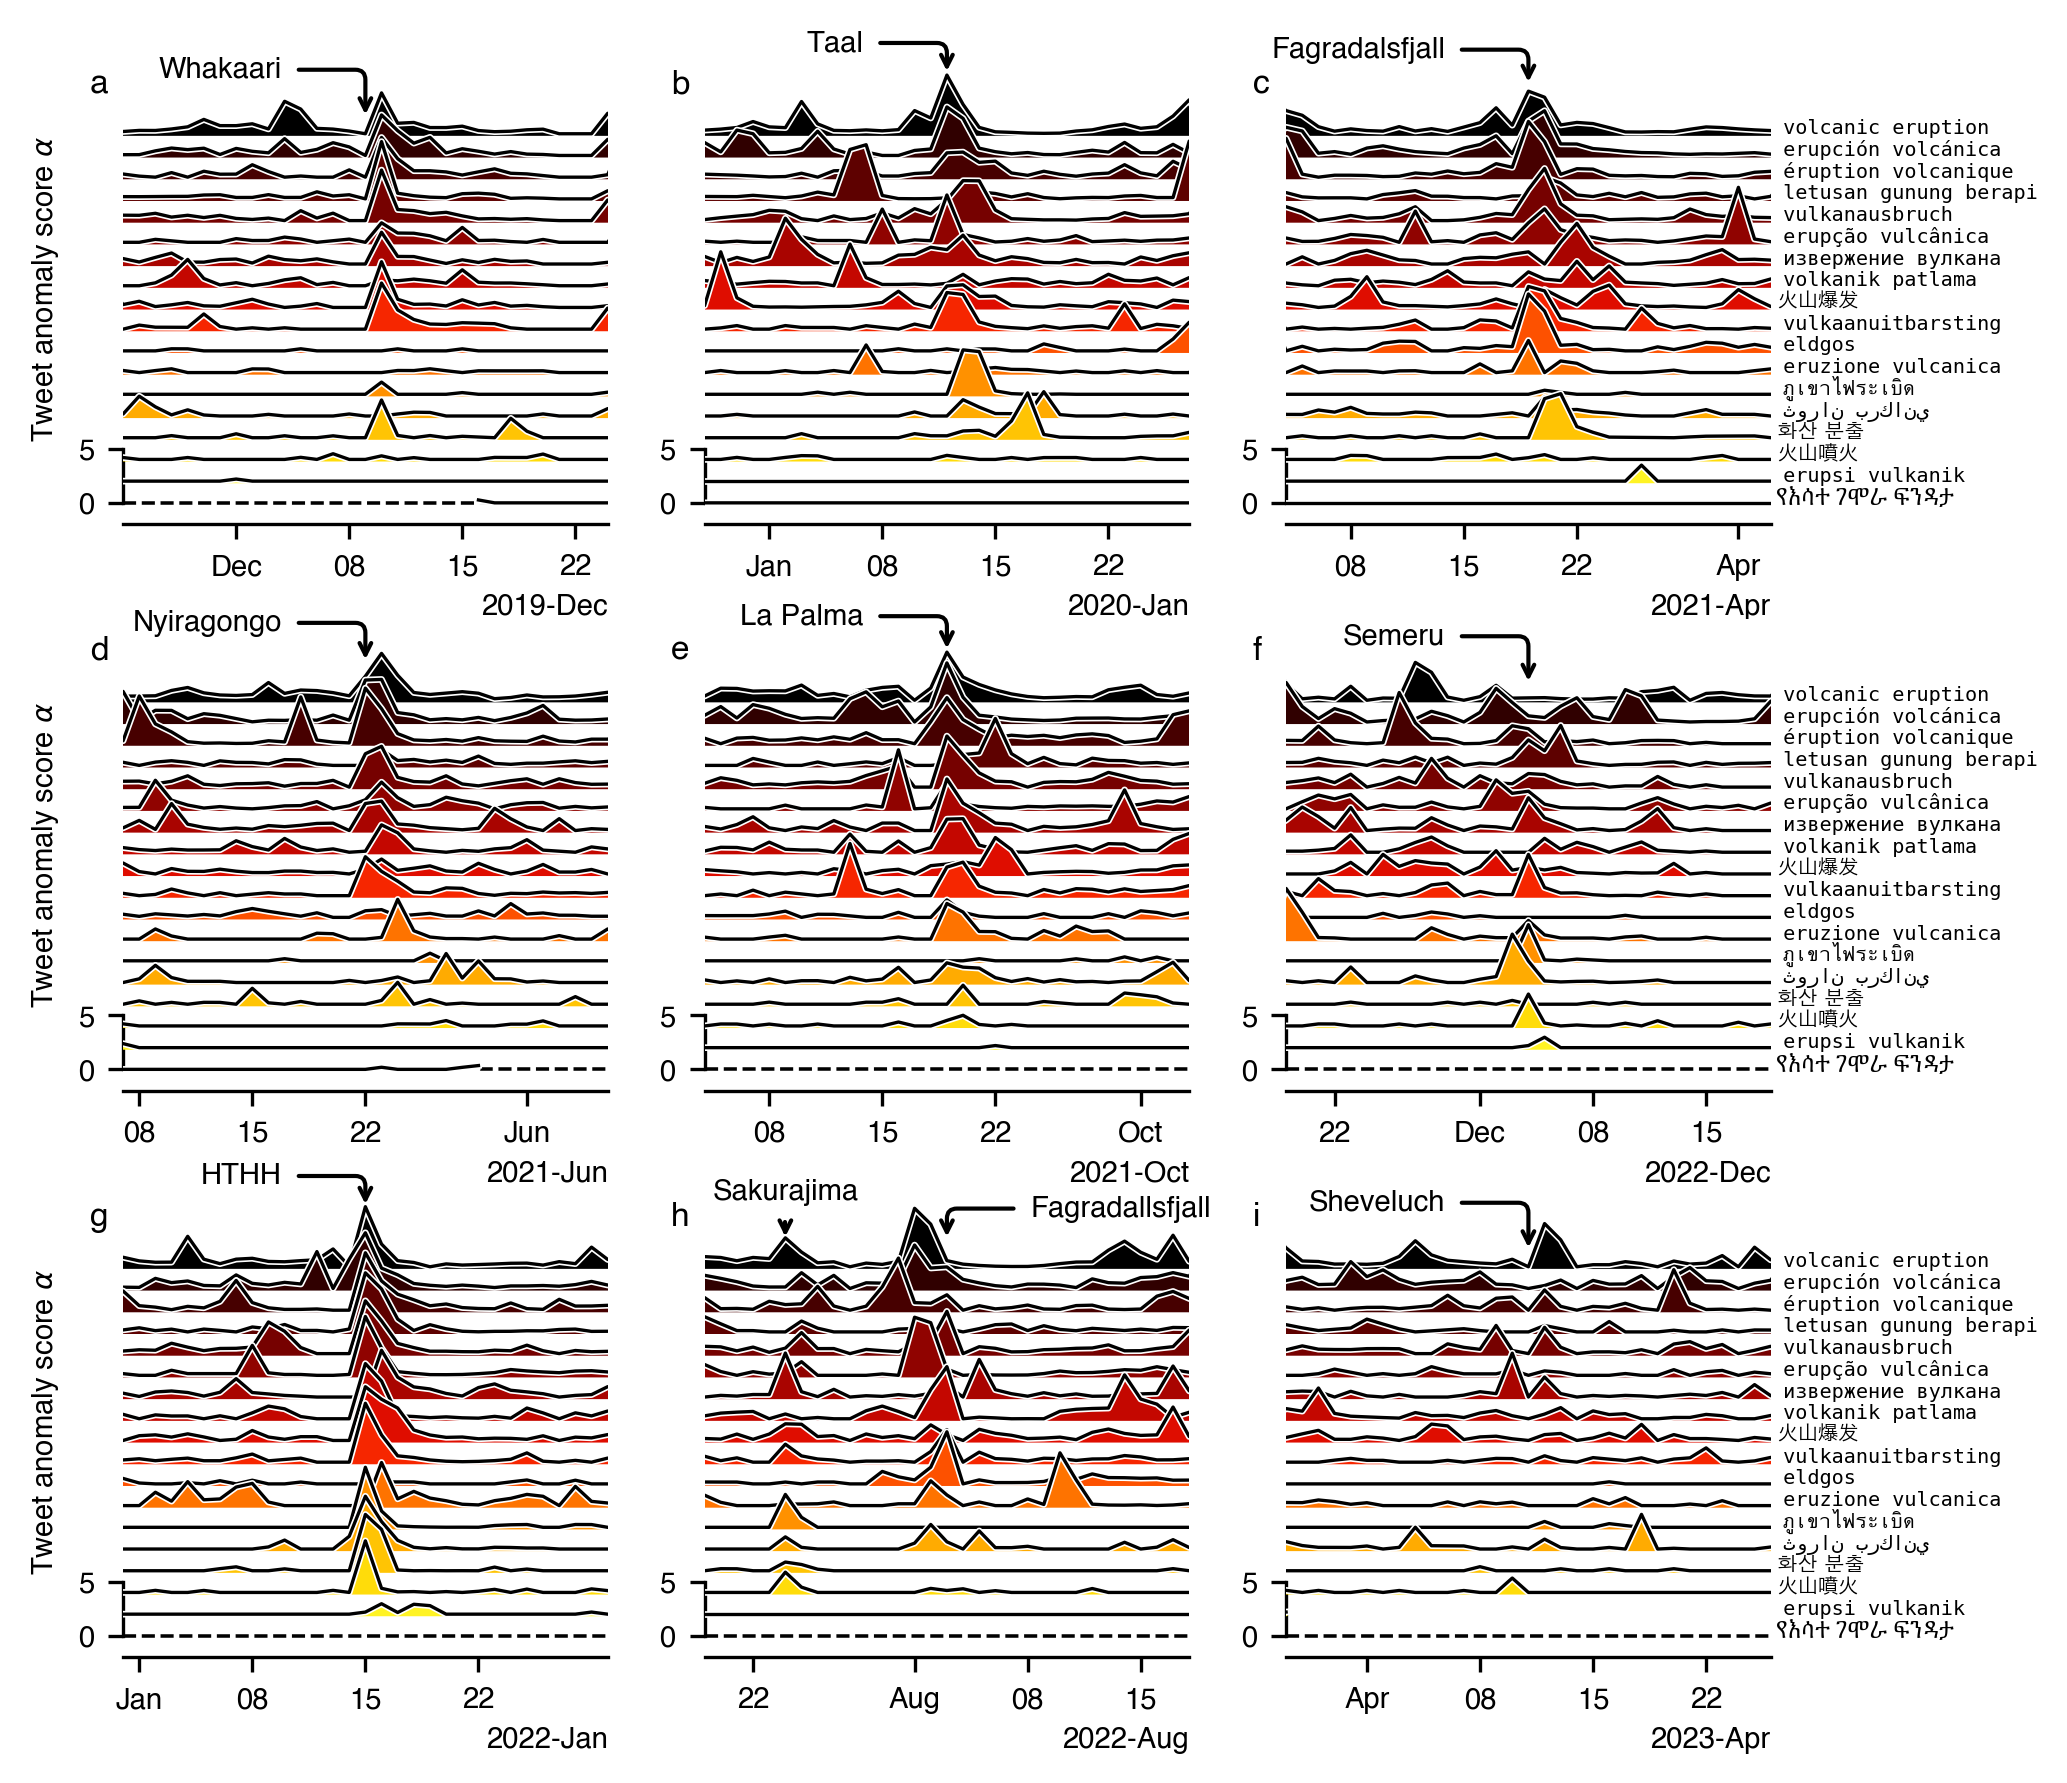

In [16]:
fig = plt.figure(1, figsize = mm2inch(180,180), dpi = 300)
axs= [fig.add_subplot(331),fig.add_subplot(332),fig.add_subplot(333),
      fig.add_subplot(334),fig.add_subplot(335),fig.add_subplot(336),
      fig.add_subplot(337),fig.add_subplot(338),fig.add_subplot(339),]


eruptDict = {"Whakaari": "2019-12-09",
             "Fagradalsfjall(1)":"2021-03-19",
             "Nyiragongo":"2021-05-22",
              "La Palma": "2021-09-19",
             "Semeru":"2021-12-4",
            "HTHH":"2022-01-15",
              "Kilauea":"2022-12-09",
             "Fagradalsfjall(2)":"2022-08-03",
             "Taal":"2020-04-12" ,
             "Anak Krakatau": "2022-08-02",
             
}

erupts = ["Whakaari","Taal","Fagradalsfjall",
          "Nyiragongo","La Palma","Semeru", 
          "HTHH", "Fagradalsfjall", "Sheveluch"]
    
datelist = ["2019-12-09", "2020-01-12", "2021-03-19",
            "2021-05-22", "2021-09-19","2022-12-04",
            "2022-01-15", "2022-08-03", "2023-04-11"
            ]

offsets = [0,4,3,
           2,3,0,
           4,3,0]

i = 0

for i in range(9):
    for ix, st in enumerate((string2abbr(x) for x in table_df["String"].values)):#tweet_counts_dict.keys()):

        ax=axs[i]
        start = pd.Timestamp(datelist[i])-pd.Timedelta(15, unit="d")
        finish = pd.Timestamp(datelist[i])+pd.Timedelta(15, unit="d")


        c = pd.DataFrame(tweet_counts_dict[st])
        c["mean"] = c["id"].rolling('7D').mean()
        c["scale_func"] = c["id"]/(m*c["mean"]+b)

 
        ax.plot(c["scale_func"]+2*ix, "-", lw=1.6, color='w', zorder = 20-ix)
        ax.plot(c["scale_func"]+2*ix, "-", lw=0.8, color='k', zorder = 20-ix)
        ax.fill_between(c.index, 2 * ix, c["scale_func"] + 2 * ix, color=cmap((17-ix) / (17)),
                         alpha=1, zorder = 20-ix)

        if i in [2,5,8]:
                lan = cld3.get_language(st)[0]
                ax.annotate(" {}".format(abbr2string(st).lower()), fontname=alt_font(lan), xy = (
                  finish, (2*ix)),fontsize='x-small', xycoords ="data")
    axs[i].set_xlim( start , finish   )
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=14))  # Adjust interval as needed
    ax.spines["left"].set_bounds(0,5)
    ax.set_yticks([0,5])
    ax.axhline(0, color='k',lw=0.85, ls='--')
    for sp in ["top", "right"]:
        ax.spines[sp].set_visible(False)
    if i%3==0:
        ax.set_ylabel(r"Tweet anomaly score $\alpha$")
    
    locator = mdates.AutoDateLocator(minticks=3, maxticks=6)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    
    
    ax.annotate(STRING.ascii_lowercase[i], (0, 1),xytext=(-8, -4),
                      xycoords='axes fraction',textcoords='offset points',
    color='k',fontsize = 8, weight='bold',#path_effects = buffer,
                ha='left', va='top', zorder = 1000)
    
    if not i == 7:
        ax.annotate(erupts[i], (pd.Timestamp(datelist[i]), 35+offsets[i]),xytext=(-20, 16-offsets[i]),
                          xycoords='data',textcoords='offset points',
        color='k',
                    ha='right', va='top', zorder = 1000,
                    arrowprops=dict(arrowstyle="->",
                                connectionstyle="angle,angleA=0,angleB=90,rad=10"))
axs[7].annotate("Sakurajima", (pd.Timestamp("2022-7-24"), 36),xytext=(0, 16),
                      xycoords='data',textcoords='offset points',
    color='k',
                ha='center', va='top', zorder = 1000,
                arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle,angleA=0,angleB=90,rad=10"))
axs[7].annotate("Fagradallsfjall", (pd.Timestamp("2022-08-03"), 36),xytext=(20, 12),
                      xycoords='data',textcoords='offset points',
    color='k',
                ha='left', va='top', zorder = 1000,
                arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle,angleA=0,angleB=90,rad=10"))

plt.savefig("Figures/Figure1.svg", bbox_inches="tight")
plt.savefig("Figures/Figure1.png", bbox_inches="tight")
plt.show()

### Caption ###

**Figure 1: Timeseries of heightened Twitter activity with respect to major volcanic events.** Each panel comprises 30–31 days of the anomaly score $\alpha$ for each of the 18 studied strings (see Table 1). Timeing of notable volcanic eruptions are highlighted by arrows: a) Whakaari (Aotearoa New Zealand); b) Taal (Philippines); c) Fagradjallsfjall (Iceland); d) Nyiragongo (Democratic Republic of the Congo); e) La Palma (Cumbre Vieja; Spain); f) Gunung Semeru (Indonesia); g) Hunga Tonga–Hunga Haʻapai (Tonga); h) Sakurajima (Japan) and Fagradjallsfjall; i) Sheveluch (Russia).

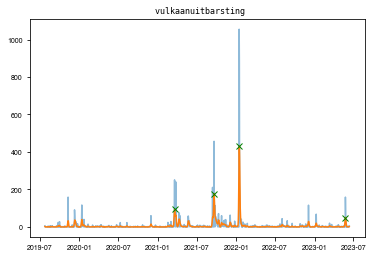

vulkaanuitbarsting 2022-01-16 00:00:00+00:00


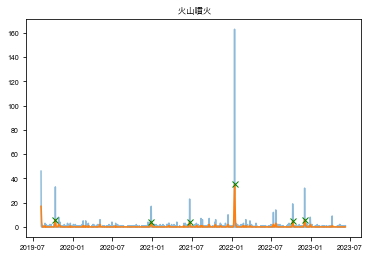

火山噴火 2022-01-15 00:00:00+00:00


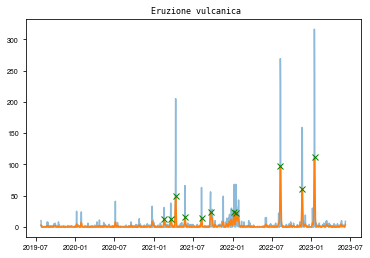

Eruzione vulcanica 2023-01-16 00:00:00+00:00


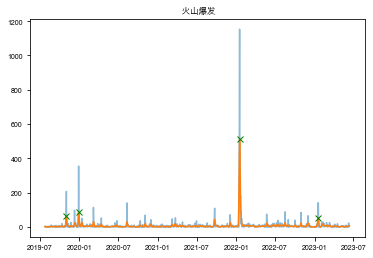

火山爆发 2022-01-17 00:00:00+00:00


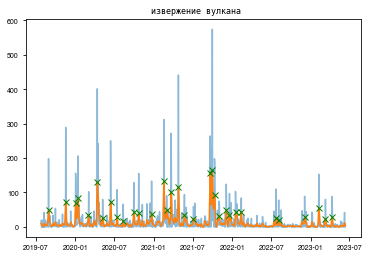

извержение вулкана 2021-09-30 00:00:00+00:00


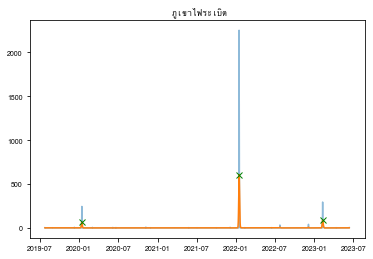

ภูเขาไฟระเบิด 2022-01-15 00:00:00+00:00


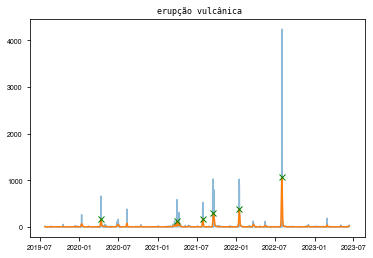

erupção vulcânica 2022-08-02 00:00:00+00:00


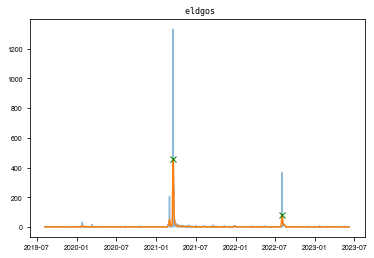

eldgos 2021-03-20 00:00:00+00:00


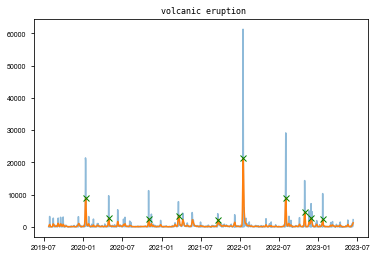

volcanic eruption 2022-01-16 00:00:00+00:00


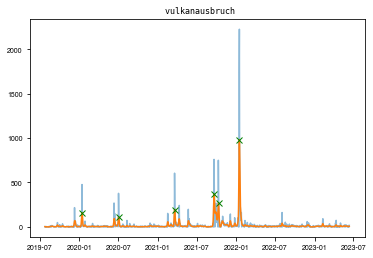

vulkanausbruch 2022-01-16 00:00:00+00:00


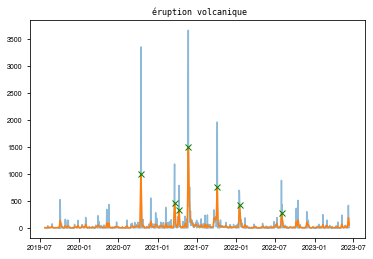

éruption volcanique 2021-05-23 00:00:00+00:00


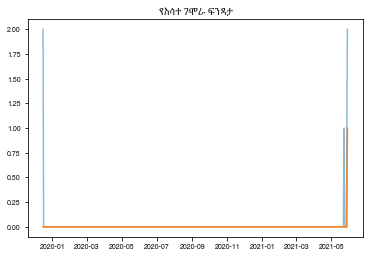

የእሳተ ገሞራ ፍንዳታ Err


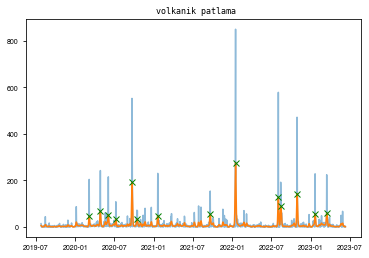

volkanik patlama 2022-01-16 00:00:00+00:00


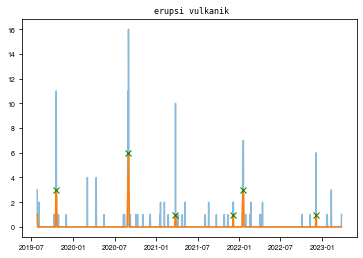

erupsi vulkanik 2020-08-31 00:00:00+00:00


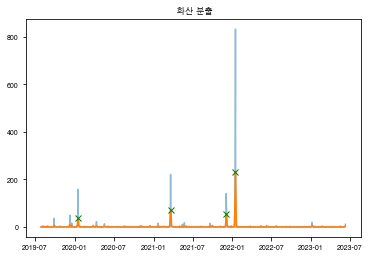

화산 분출 2022-01-16 00:00:00+00:00


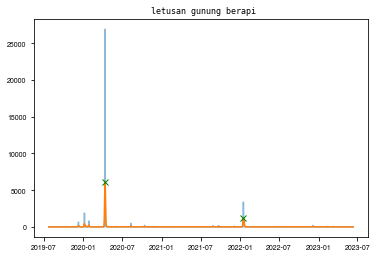

letusan gunung berapi 2020-04-12 00:00:00+00:00


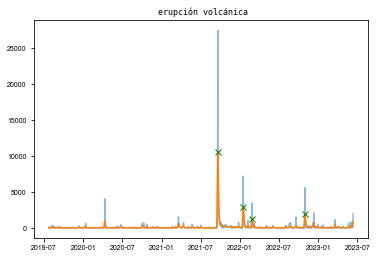

erupción volcánica 2021-09-20 00:00:00+00:00


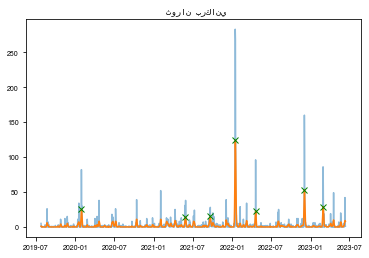

ثوران بركاني 2022-01-16 00:00:00+00:00


In [17]:
'''
Event matching through smoothed signal peak detection: 
confirm that peaks in alpha are programmatically detectable
'''


for ix, st in enumerate(tweet_counts_dict.keys()):
    counts = tweet_counts_dict[st]


    c = pd.DataFrame(tweet_counts_dict[st])
    c["smoothed_event_counts"] = gaussian_filter1d(c['id'], sigma=2)

    y = c["smoothed_event_counts"]
    t = c.index
    
    peaks_, _ = find_peaks(y/max(y), prominence=0.1)
    plt.plot(t,c["id"],alpha=.5)
    plt.plot(t[peaks_], y[peaks_], "xg",zorder = 100)
    plt.plot(t,y)
    lan = cld3.get_language(st)[0]
    plt.title(" {}".format(abbr2string(st)), fontname=alt_font(lan))
    plt.show()
    try: 
        maxDate = t[peaks_][np.argmax(y[peaks_])]
    except:
        maxDate = "Err"
    print(abbr2string(st), maxDate)

In [18]:
''' scale counts as a function of short-term average '''
normalised_dict = {}
for ix, st in enumerate(tweet_counts_dict.keys()):
    c = pd.DataFrame(tweet_counts_dict[st])
    c["mean"] = c["id"].rolling('7D').mean()
    c["scale_func"] = c["id"]/(m*c["mean"]+b)
    normalised_dict[st] = c["scale_func"]

In [19]:
''' there are some minor differences in timeseries index between strings '''
tweet_counts_dict_common ={}
all_dates = []
for ix, st in enumerate(tweet_counts_dict.keys()):
    counts = tweet_counts_dict[st]
    all_dates.extend(counts.index)

# Create a common daily index
common_index = pd.date_range(start=min(all_dates), end=max(all_dates), freq='D')

# reindex each time series to the common index
for ix, st in enumerate(tweet_counts_dict.keys()):
    counts = tweet_counts_dict[st]
    # Reindex the time series to the common index
    counts_reindexed = counts.reindex(common_index)
    tweet_counts_dict_common[st] = counts_reindexed  # Update the dictionary with the reindexed series
    tweet_counts_dict_common[st] = tweet_counts_dict_common[st]["id"].fillna(0)

### Figure 2 ###

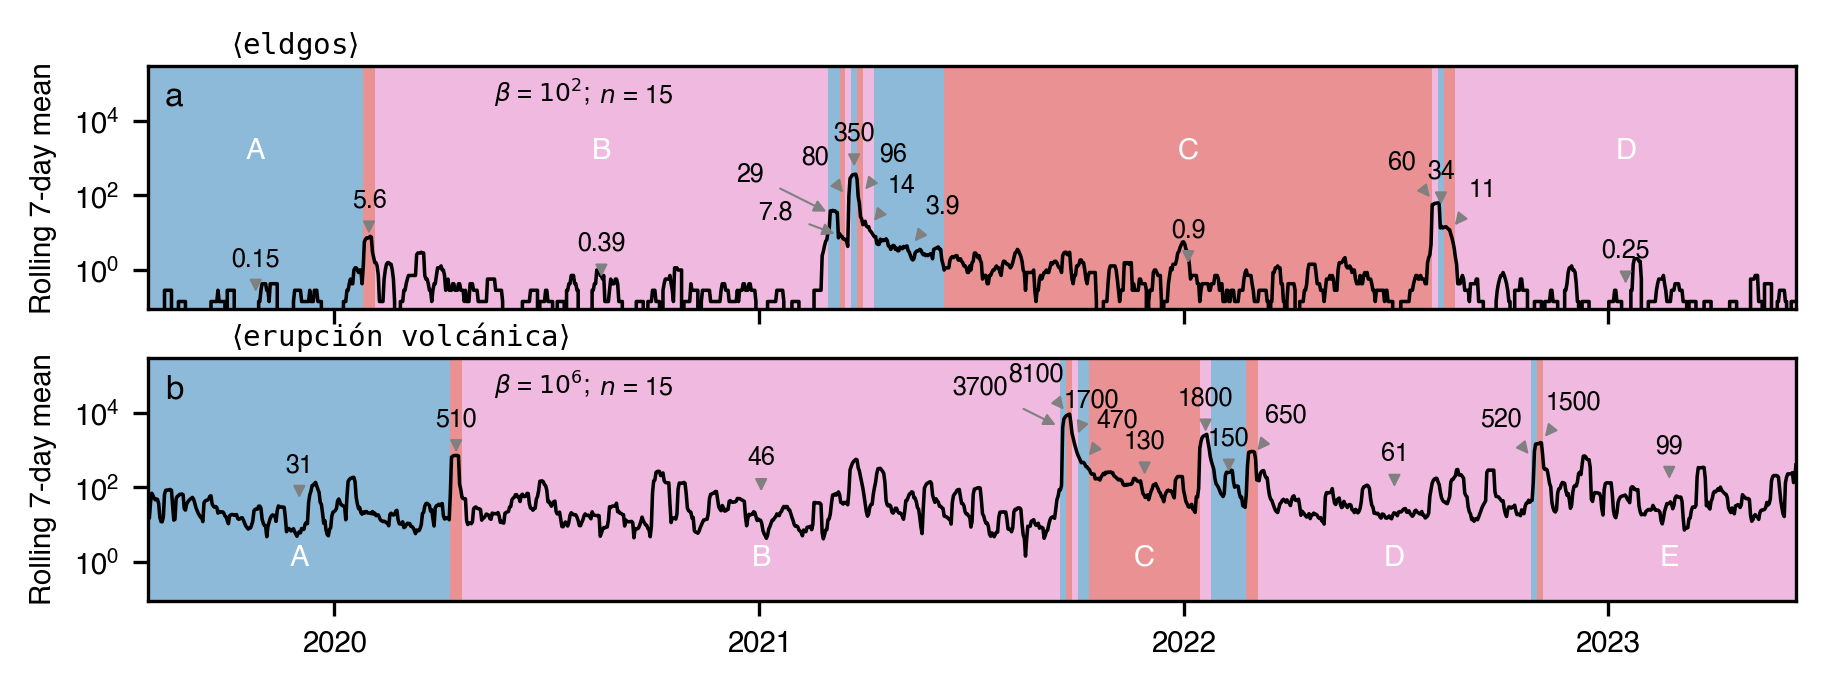

In [20]:
fig = plt.figure(1, figsize=mm2inch(180, 60), dpi=300)
axs = [plt.subplot2grid((2, 1), (0, 0), colspan=1, rowspan=1),
       plt.subplot2grid((2, 1), (1, 0), colspan=1, rowspan=1)]

volcanoes = ["eldgos", "erupción"] 
y_lower = [.9e-1, .9e-1]
y_upper = [3e5, 3e5]

segment_dict = {}
for ix, ax in enumerate(axs):
    st = volcanoes[ix]
    volcanic_data = tweet_counts_dict_common[st]
    volcanic_data = pd.Series(volcanic_data).rolling('7D').mean().dropna().values
    
    # fit ls model
    model = "l2"  # Least squares method
    algo = rpt.Pelt(model=model).fit(volcanic_data)
    
    change_points = algo.predict(pen=[1e2, 1e6][ix])
    change_points = change_points[:-1] + [len(common_index)-1]

    # plot the time series
    ax.plot(common_index, volcanic_data, color="k", lw=0.85,)# alpha =0.2)

    # extract the segment means and plot the mean value in the middle of each segment
    segment_means = []
    segment_centres = []
    start = 0
    xoff_eld = [0,0,0,-20,-16,-8,0,8,8,8,0,-8,0,8,0]
    xoff_eru = [0,0,0,-20,-8,4,8,0,0,0,8,0,-8,8,0,]
    xoff = xoff_eld if ix ==0 else xoff_eru
    segment_data =[]    
    for i, cp in enumerate(change_points):
        segment = volcanic_data[start:cp]
        segment_mean = np.mean(segment)
        segment_data.append(segment)
        
        # calculate the centre of the segment using time index
        segment_centre = common_index[start] + (common_index[cp] - common_index[start]) / 2
        segment_means.append(segment_mean)
        segment_centres.append(segment_centre)

        yoff = -4 if i == 4 and ix == 0 else 0 
        ax.annotate('{:g}'.format(float('{:.2g}'.format(segment_mean))),
           xy = (segment_centre,segment_mean),#label_ys[i]),
                   xycoords="data", xytext =(xoff[i],10+yoff), 
                    textcoords ="offset points", ha="center", va="center", size=6,
                   arrowprops=dict(arrowstyle="-|>", color='gray', lw=0.5))
        start = cp  # update start position for the next segment
    
    # shade rupture-detected sections
    start = common_index[0]
    segment_dict[st] = segment_data
    pu_cmap = plt.get_cmap("tab10")
    colours = [pu_cmap(i / 3) for i in range(3)]
    for i, cp in enumerate(change_points):
        colour = colours[i % len(colours)]  # cycle through the colours list using modulo operation
        ax.axvspan(start, common_index[cp], color=colour, alpha=0.5, ec="none")  # apply colour
        start = common_index[cp]  # update start position for the next segment

    ax.set_yscale("log")
    lan = cld3.get_language(st)[0]
    ax.annotate(r"$\langle${}$\rangle$".format(abbr2string(st).lower()), fontname=alt_font(lan), 
                xy=(0.05, 1.05), xycoords="axes fraction")
    
    ax.set_ylim(y_lower[ix], y_upper[ix])
    locator = mdates.AutoDateLocator(minticks=3, maxticks=6)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    
    ax.annotate(STRING.ascii_lowercase[ix], (0, 1), xytext=(4, -4),
                xycoords='axes fraction', textcoords='offset points',
                color='k', fontsize=8, weight='bold', ha='left', va='top', zorder=1000)
    ax.set_xlim(min(common_index), max(common_index))
    ax.set_ylabel("Rolling 7-day mean")
    
    ax.annotate(r"$\beta$ = $10^{{{:.0f}}}$;".format(np.log10([1e2, 1e6][ix])),
                xy=(0.21,0.85), xycoords="axes fraction", size=6)
    ax.annotate(r" $n$ = {}".format(len(change_points)),
                xy=(0.27,0.85), xycoords="axes fraction", size=6)
    
    if ix == 0:
        for j, segment in enumerate([0,2,10,14]):
            ax.annotate(STRING.ascii_uppercase[j], xy = (segment_centres[segment], 1e3),
                       ha="center", color="w")
            
    else:
         for j, segment in enumerate([0,2,7, 11, 14]):
            ax.annotate(STRING.ascii_uppercase[j], xy = (segment_centres[segment], .8e0),
                       ha="center", color="w")
axs[0].xaxis.set_ticklabels([])

plt.savefig("Figures/Figure2.svg", bbox_inches="tight")
plt.savefig("Figures/Figure2.png", bbox_inches="tight")
plt.show()


### Caption ###
**Figure 2: Statistically segmented timeseries of mean scaled tweet counts.** Timeseries for 〈eldgos〉 and 〈erupción volcánica〉 are shown in a and b, respectively. Each consecutive shaded region has internally consistent statistical properties, and each transition between segments is a statistically determined changepoint. The mean value of each segment is annotated (2 s.f.). Note logarithmic y-axes. “Quiescent” periods are denoted by A, B, etc. The value n indicates the number of segments determined for a given $\beta$ value.

In [21]:
'''
Perform parametric (t-test) and non-parametric tests on quiescent segment data.
'''
segment_dict.keys()
eld_indices = [0,2,10,14]
eru_indices = [0,2,7, 11, 14]

atom = 1e-3 # small constant to account for zeros

for i, key in enumerate(segment_dict.keys()):
    indices = eld_indices if i == 0 else eru_indices
    
    segment_data = segment_dict[key]
    
    print('\n#####################\n{}\n#####################'.format(key))
        # Pairwise comparisons
    for i in range(len(indices) - 1):
        seg1, seg2 = segment_data[indices[i]], segment_data[indices[i+1]]

        # Mann-Whitney U test
        u_stat, p_val = mannwhitneyu(seg1, seg2, alternative='two-sided')
        print("MW Test segment {} vs {}: U={}, p={}".format(
            STRING.ascii_uppercase[i], STRING.ascii_uppercase[i+1], u_stat, p_val 
        
        ))

        # Log-transformed t-test 
        t_stat, p_val_t = ttest_ind(np.log(seg1+atom), np.log(seg2+atom), equal_var=False)
        print("Log t-test {} vs {}: t={}, p={}".format(
        STRING.ascii_uppercase[i], STRING.ascii_uppercase[i+1], t_stat, p_val_t
        ))


#####################
eldgos
#####################
MW Test segment A vs B: U=23674.5, p=7.142306190782028e-12
Log t-test A vs B: t=-7.367584101580029, p=1.463358192832779e-12
MW Test segment B vs C: U=40734.5, p=8.815866445596882e-36
Log t-test B vs C: t=-11.127369623352584, p=1.8408112810347694e-26
MW Test segment C vs D: U=99639.5, p=8.405293016898207e-46
Log t-test C vs D: t=13.69191576486545, p=1.1283280291728034e-35

#####################
erupción
#####################
MW Test segment A vs B: U=62111.0, p=0.10011143176958912
Log t-test A vs B: t=-2.4013029782887516, p=0.016621395805755234
MW Test segment B vs C: U=6017.0, p=1.4932677585507621e-31
Log t-test B vs C: t=-18.15705843969859, p=1.8205916401960633e-43
MW Test segment C vs D: U=18312.0, p=8.219998060273943e-20
Log t-test C vs D: t=11.744794970703966, p=3.092446492017384e-25
MW Test segment D vs E: U=19248.5, p=4.8153778155498914e-06
Log t-test D vs E: t=-4.361960999885384, p=1.6161534807635233e-05


### Figure 3 ###

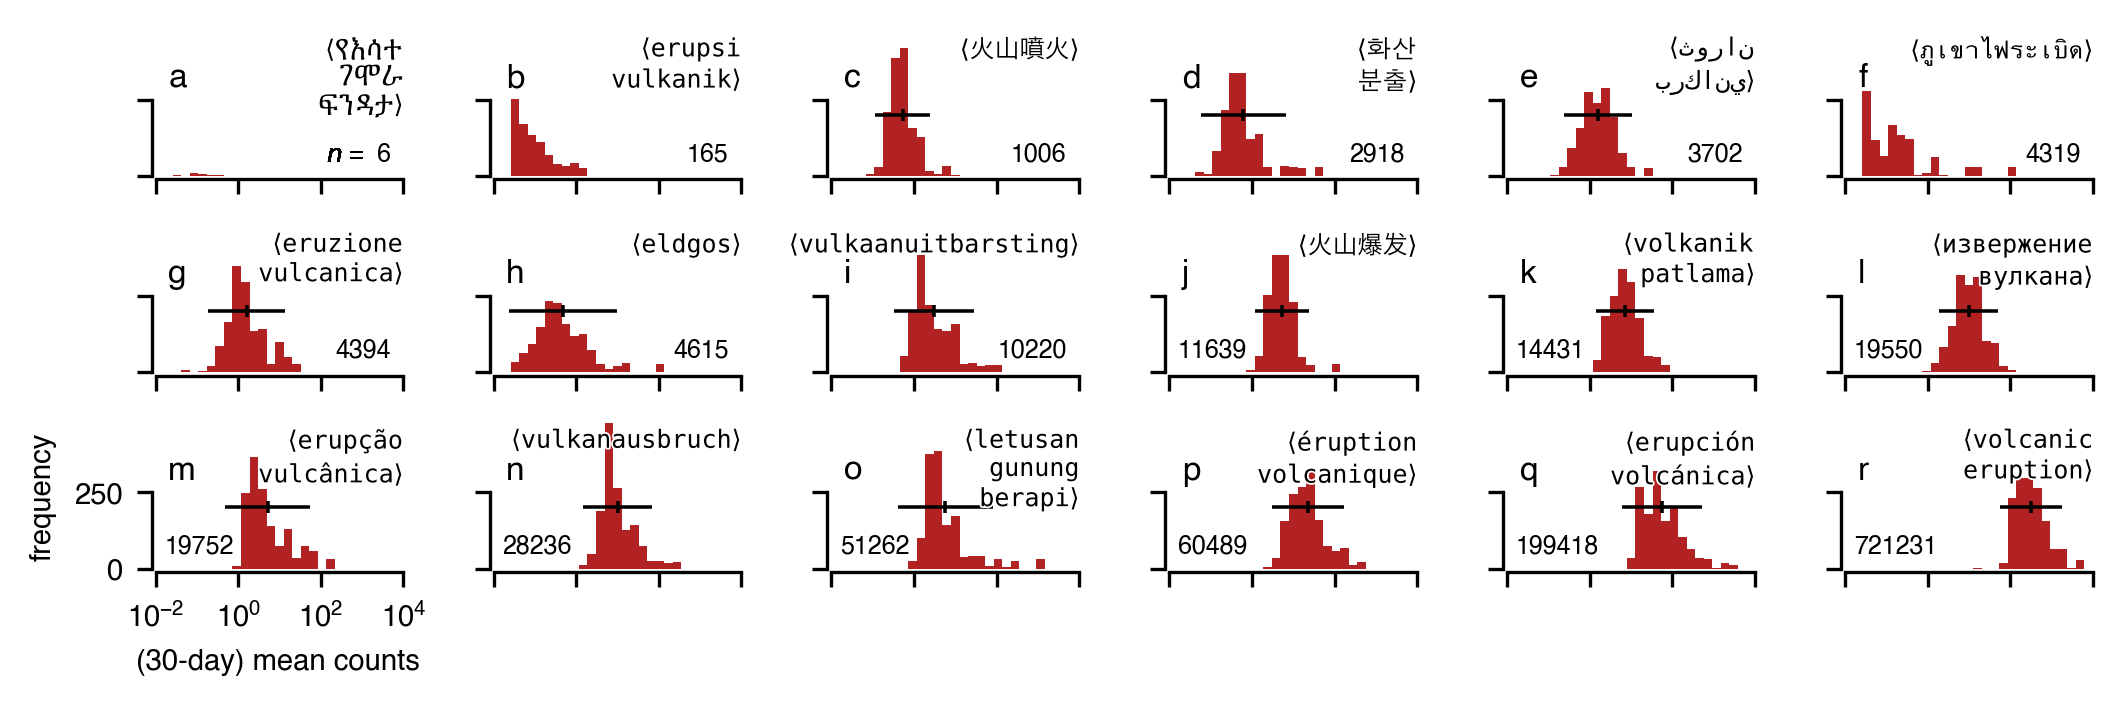

In [22]:
fig = plt.figure(1, figsize=(mm2inch(180,60)), dpi = 300)
axs = [fig.add_subplot(361),
      fig.add_subplot(362),
      fig.add_subplot(363),
      fig.add_subplot(364),
      fig.add_subplot(365),
      fig.add_subplot(366),
      fig.add_subplot(367),
      fig.add_subplot(368),
      fig.add_subplot(369),
      fig.add_subplot(3,6,10),
      fig.add_subplot(3,6,11),
      fig.add_subplot(3,6,12),
      fig.add_subplot(3,6,13),
      fig.add_subplot(3,6,14),
      fig.add_subplot(3,6,15),
      fig.add_subplot(3,6,16),
      fig.add_subplot(3,6,17),
      fig.add_subplot(3,6,18),]

for ix, st in enumerate((string2abbr(x) for x in table_df["String"].values)):
    counts = tweet_counts_dict[st]
    ax = axs[ix]
    month_av = counts["id"].rolling('30D').mean()
    try:


        log_transformed_data = np.log10(month_av)
        ax.hist(month_av,
                bins=np.geomspace(1e-2,1e4, 30),
                density=False, color="firebrick")
    except:
        continue
    ax.set_ylim(-10,480)
    ax.set_xscale("log")
    ax.set_xlim(.008,1e4)
    ax.set_xticks([1e-2,1e0,1e2,1e4])  
    ax.spines["left"].set_bounds(0,250)
    ax.spines["bottom"].set_bounds(.01,1e4)
    if ix ==12:
        ax.set_xlabel('(30-day) mean counts')
        ax.set_ylabel('frequency')
        
    else:
        ax.set_xlabel("")
        ax.set_xticklabels("")
        ax.set_ylabel("")
        ax.set_yticklabels("")
        
        
    lan = cld3.get_language(st)[0]

    ax.annotate(r"$\langle${}$\rangle$".format(abbr2string(st).replace(' ', '\n').lower()) , xy = (1,.96),
                xycoords="axes fraction", va="top", 
                ha="right",
               fontname=alt_font(lan), fontsize=6, path_effects=buffer)
    
    ax.annotate(STRING.ascii_lowercase[ix], (0, 1), xytext=(4, -8),
                xycoords='axes fraction', textcoords='offset points',
                color='k', fontsize=8, weight='bold', ha='left', va='top', zorder=1000)
    
    mean = 10**np.nanmean(np.log10(month_av))
    two_sigma_up = 10**(np.nanmean(np.log10(month_av))+
                    (2*np.nanstd(np.log10(month_av))))
    two_sigma_dn = 10**(np.nanmean(np.log10(month_av))-
                    (2*np.nanstd(np.log10(month_av))))

    ax.hlines(200, two_sigma_dn, two_sigma_up, color="k", lw=.85, clip_on = False)
    ax.vlines(mean, 180, 220, color="k", lw=.85, clip_on = False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    if ix <9 :
        ax.annotate(sum(counts["id"].values), xy = (0.95,.25),
                xycoords="axes fraction", va="top", 
                ha="right",
               fontsize=6, )##path_effects=buffer)
    else:
        ax.annotate(sum(counts["id"].values), xy = (0.05,.25),
                xycoords="axes fraction", va="top", 
                ha="left",
               fontsize=6, )
    axs[0].annotate(r"$n$ = ", xy = (0.85,.25),
                xycoords="axes fraction", va="top", 
                ha="right",
               fontsize=6, )

plt.savefig("Figures/Figure3.svg", bbox_inches="tight")
plt.savefig("Figures/Figure3.png", bbox_inches="tight")
plt.tight_layout()

### Caption ###

**Figure 3: Post count distribution broken down by language.** Histograms of 30-day mean counts of each timeseries are shown in a to r. Axes are the same for all panels. Black crosses show mean 〈c〉  and 2 standard deviation range calculated assuming a lognormal distribution (not performed for a, b, and f which have visibly different distributions). The number $n$ of tweets in the dataset is also shown.

In [23]:
'''Smoothing then normalisation'''


tweet_counts_dict_smoothed = tweet_counts_dict_common.copy()
tweet_counts_df_smoothed = pd.DataFrame(tweet_counts_dict_smoothed)

# apply Gaussian smoothing to each column
sigma = 2  # 
for col in tweet_counts_df_smoothed.columns:
    tweet_counts_df_smoothed[col] = gaussian_filter1d(tweet_counts_df_smoothed[col], sigma)
    


# z-Score normalisation
tweet_counts_dict_normalised = {}
for key, series in tweet_counts_df_smoothed.items():
    series_mean = np.mean(series)
    series_std = np.std(series)
    normalised_series = (series - series_mean) / series_std
    tweet_counts_dict_normalised[key] = normalised_series
    
tweet_counts_df_normalised = pd.DataFrame(tweet_counts_dict_normalised)



In [24]:
'''Calculating Euclidean and Cosine distances '''

euc_distances = {}
cos_distances = {}
    
# compute pairwise Euclidean and Cosine distances
for (st1, st2) in combinations(tweet_counts_df_normalised.columns, 2):
    series_1 = tweet_counts_df_normalised[st1].values
    series_2 = tweet_counts_df_normalised[st2].values

    # (a) Euclidean distance
    euclidean_distance = euclidean(series_1, series_2)
    euc_distances[(st1, st2)] = euclidean_distance
    # (b) Cosine distance
    cosine_distance = cosine(series_1, series_2)
    cos_distances[(st1, st2)] = cosine_distance
    print(f"Series {st1} vs {st2}:")
    print(f"Euclidean Distance: {euclidean_distance:.4f}")
    print(f"Cosine Distance: {cosine_distance:.4f}")


Series vulkaanuitbarsting vs 火山噴火:
Euclidean Distance: 25.7287
Cosine Distance: 0.2333
Series vulkaanuitbarsting vs Eruzione:
Euclidean Distance: 47.6728
Cosine Distance: 0.8008
Series vulkaanuitbarsting vs 火山爆发:
Euclidean Distance: 23.7143
Cosine Distance: 0.1982
Series vulkaanuitbarsting vs извержение:
Euclidean Distance: 43.6656
Cosine Distance: 0.6718
Series vulkaanuitbarsting vs ภูเขาไฟระเบิด:
Euclidean Distance: 21.4512
Cosine Distance: 0.1621
Series vulkaanuitbarsting vs erupção:
Euclidean Distance: 41.5445
Cosine Distance: 0.6082
Series vulkaanuitbarsting vs eldgos:
Euclidean Distance: 47.9680
Cosine Distance: 0.8108
Series vulkaanuitbarsting vs volcanic:
Euclidean Distance: 23.5346
Cosine Distance: 0.1952
Series vulkaanuitbarsting vs vulkanausbruch:
Euclidean Distance: 12.4872
Cosine Distance: 0.0549
Series vulkaanuitbarsting vs éruption:
Euclidean Distance: 44.3069
Cosine Distance: 0.6917
Series vulkaanuitbarsting vs የእሳተ:
Euclidean Distance: 51.9615
Cosine Distance: 0.9514
S

In [25]:
'''Cosine distance matrix'''

# initialise empty distance matrix
series_names = tweet_counts_df_normalised.columns
n_series = len(series_names)
cos_distance_matrix = np.zeros((n_series, n_series))

# fill the matrix with distances
for (st1, st2), distance in cos_distances.items():
    i = series_names.get_loc(st1)
    j = series_names.get_loc(st2)
    cos_distance_matrix[i, j] = distance
    cos_distance_matrix[j, i] = distance  # Symmetric

# xonvert to a DataFrame 
cos_distance_matrix_df = pd.DataFrame(cos_distance_matrix, index=series_names, columns=series_names)


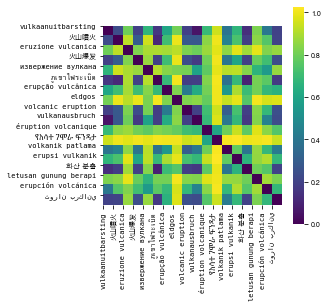

In [26]:
# plot Cosine distance matrix
plt.figure(figsize=(4,4))

A = cos_distance_matrix_df

sns.heatmap(A, cmap="viridis", square=True,)

new_tick_labels = [abbr2string(st).lower() for st in A.columns]
tick_font_dict = {}
for st in A.columns:
    lan = cld3.get_language(st)[0]  # Get the language for the column name
    tick_font_dict[st] = alt_font(lan)  
for tick_label, tick_text in zip(plt.gca().get_xticklabels(), A.columns):
    lan = cld3.get_language(tick_text)[0]
    tick_label.set_fontname(alt_font(lan))
for tick_label, tick_text in zip(plt.gca().get_yticklabels(), A.index):
    lan = cld3.get_language(tick_text)[0]
    tick_label.set_fontname(alt_font(lan))
plt.xticks(ticks=np.arange(len(new_tick_labels)), labels=new_tick_labels, rotation=90)
plt.yticks(ticks=np.arange(len(new_tick_labels)), labels=new_tick_labels, rotation=0)

plt.show()

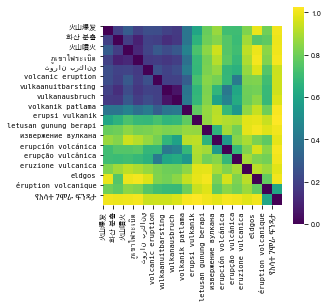

In [27]:
# Order matrix based on "optimal leaf ordering"
plt.figure(figsize=(4,4))

# linkage_matrix = linkage(A, method='average', metric='cosine')
linkage_matrix = linkage(A, method='ward', metric='euclidean')
linkage_matrix_opt = optimal_leaf_ordering(linkage_matrix, A)
optimal_order = leaves_list(linkage_matrix_opt)
B = A.iloc[optimal_order, optimal_order]

sns.heatmap(B, cmap="viridis", square=True,)

new_tick_labels = [abbr2string(st).lower() for st in B.columns]
for st in B.columns:
    lan = cld3.get_language(st)[0]  # Get the language for the column name
    tick_font_dict[st] = alt_font(lan)  
for tick_label, tick_text in zip(plt.gca().get_xticklabels(), B.columns):
    lan = cld3.get_language(tick_text)[0]
    tick_label.set_fontname(alt_font(lan))
for tick_label, tick_text in zip(plt.gca().get_yticklabels(), B.index):
    lan = cld3.get_language(tick_text)[0]
    tick_label.set_fontname(alt_font(lan))
plt.xticks(ticks=np.arange(len(new_tick_labels)), labels=new_tick_labels, rotation=90)
plt.yticks(ticks=np.arange(len(new_tick_labels)), labels=new_tick_labels, rotation=0)

plt.show()

In [28]:
'''Define a dict for order based on tweet volume'''
volume_dict = {}
for key, val in tweet_counts_dict.items():
#     print(key, sum(tweet_counts_dict[key].id.values))
    volume_dict[key] = sum(tweet_counts_dict[key].id.values)
    
    
#Sort dict by values (descending)
sorted_volume_keys = sorted(volume_dict, key=volume_dict.get, reverse=True)


In [29]:
'''Reorder matrix based on volume'''

C = B.copy()

# reorder DataFrame rows and columns
C = C.loc[sorted_volume_keys, sorted_volume_keys]
C

,volcanic,erupción,éruption,letusan,vulkanausbruch,erupção,извержение,volkanik,火山爆发,vulkaanuitbarsting,eldgos,Eruzione,ภูเขาไฟระเบิด,بركاني,화산,火山噴火,erupsi,የእሳተ
volcanic,0.000000,0.683366,0.713539,0.839147,0.198317,0.420631,0.811181,0.303836,0.237454,0.195165,0.828134,0.825699,0.181837,0.251912,0.192048,0.284296,0.724563,0.950870
erupción,0.683366,0.000000,0.847183,0.884968,0.450391,0.686448,0.555795,0.682821,0.711972,0.413099,0.960188,0.832864,0.762876,0.679172,0.751029,0.751224,0.905736,1.012300
éruption,0.713539,0.847183,0.000000,0.977475,0.687378,0.808326,0.774100,0.799383,0.805805,0.691720,0.781553,0.873037,0.834938,0.751464,0.774592,0.848217,0.941688,0.602496
letusan,0.839147,0.884968,0.977475,0.000000,0.834941,0.810203,0.662672,0.865411,0.789787,0.825864,1.010521,0.985512,0.811809,0.821369,0.802235,0.850336,0.860173,1.006331
vulkanausbruch,0.198317,0.450391,0.687378,0.834941,0.000000,0.628241,0.593108,0.412432,0.174403,0.054944,0.848517,0.795290,0.187159,0.235181,0.165210,0.277214,0.683272,0.968159
erupção,0.420631,0.686448,0.808326,0.810203,0.628241,0.000000,0.841126,0.542759,0.708239,0.608155,0.827488,0.890570,0.690067,0.656959,0.699002,0.710833,0.898380,1.007239
извержение,0.811181,0.555795,0.774100,0.662672,0.593108,0.841126,0.000000,0.918650,0.867337,0.671841,0.820817,0.895652,0.911794,0.864904,0.835769,0.951167,0.926428,0.987507
volkanik,0.303836,0.682821,0.799383,0.865411,0.412432,0.542759,0.918650,0.000000,0.398234,0.396636,0.935889,0.854300,0.374078,0.425331,0.398373,0.455706,0.775639,1.016965
火山爆发,0.237454,0.711972,0.805805,0.789787,0.174403,0.708239,0.867337,0.398234,0.000000,0.198157,0.994839,0.827196,0.198093,0.243428,0.196576,0.296265,0.605524,1.006165
vulkaanuitbarsting,0.195165,0.413099,0.691720,0.825864,0.054944,0.608155,0.671841,0.396636,0.198157,0.000000,0.810757,0.800810,0.162140,0.203357,0.134446,0.233251,0.672808,0.951374


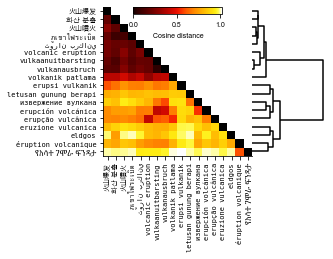

In [30]:
linkage_matrix = linkage(A, method='ward', metric='euclidean')
linkage_matrix_opt = optimal_leaf_ordering(linkage_matrix, A)
optimal_order = leaves_list(linkage_matrix_opt)
B = A.iloc[optimal_order, optimal_order]


D = np.ma.masked_array(B, mask=np.triu(
    np.ones_like(B, dtype=bool), k=1)) ## mask upper triangle, then shift up by k = 1 to include the diagonal

fig, ax = plt.subplots(figsize=(4, 4))
cmap.set_bad(color="white")  # Ensure masked values are white
heatmap = ax.imshow(D, aspect="equal", cmap=cmap)

# set ticks and labels
new_tick_labels = [abbr2string(st).lower() for st in B.columns]
plt.xticks(ticks=np.arange(len(new_tick_labels)), labels=new_tick_labels, rotation=90)
plt.yticks(ticks=np.arange(len(new_tick_labels)), labels=new_tick_labels, rotation=0)

# adjust font per language
for tick_label, tick_text in zip(plt.gca().get_xticklabels(), B.columns):
    lan = cld3.get_language(tick_text)[0]
    tick_label.set_fontname(alt_font(lan))
for tick_label, tick_text in zip(plt.gca().get_yticklabels(), B.index):
    lan = cld3.get_language(tick_text)[0]
    tick_label.set_fontname(alt_font(lan))

cax = inset_axes(ax, width="60%", height="5%", loc="upper center", borderpad=0)
cbar = fig.colorbar(heatmap, cax=cax, orientation="horizontal")
cbar.set_label("Cosine distance")

# create separate dendrogram subplot
divider = make_axes_locatable(ax)
row_ax = divider.append_axes("right", size="50%", pad=0)
dendrogram(linkage_matrix_opt, no_labels=True, orientation="right", 
           ax=row_ax, color_threshold=0, above_threshold_color="black")

row_ax.axis("off")
row_ax.invert_yaxis()

ax.spines["top"].set_visible(False) 
ax.spines["right"].set_visible(False)

plt.show()


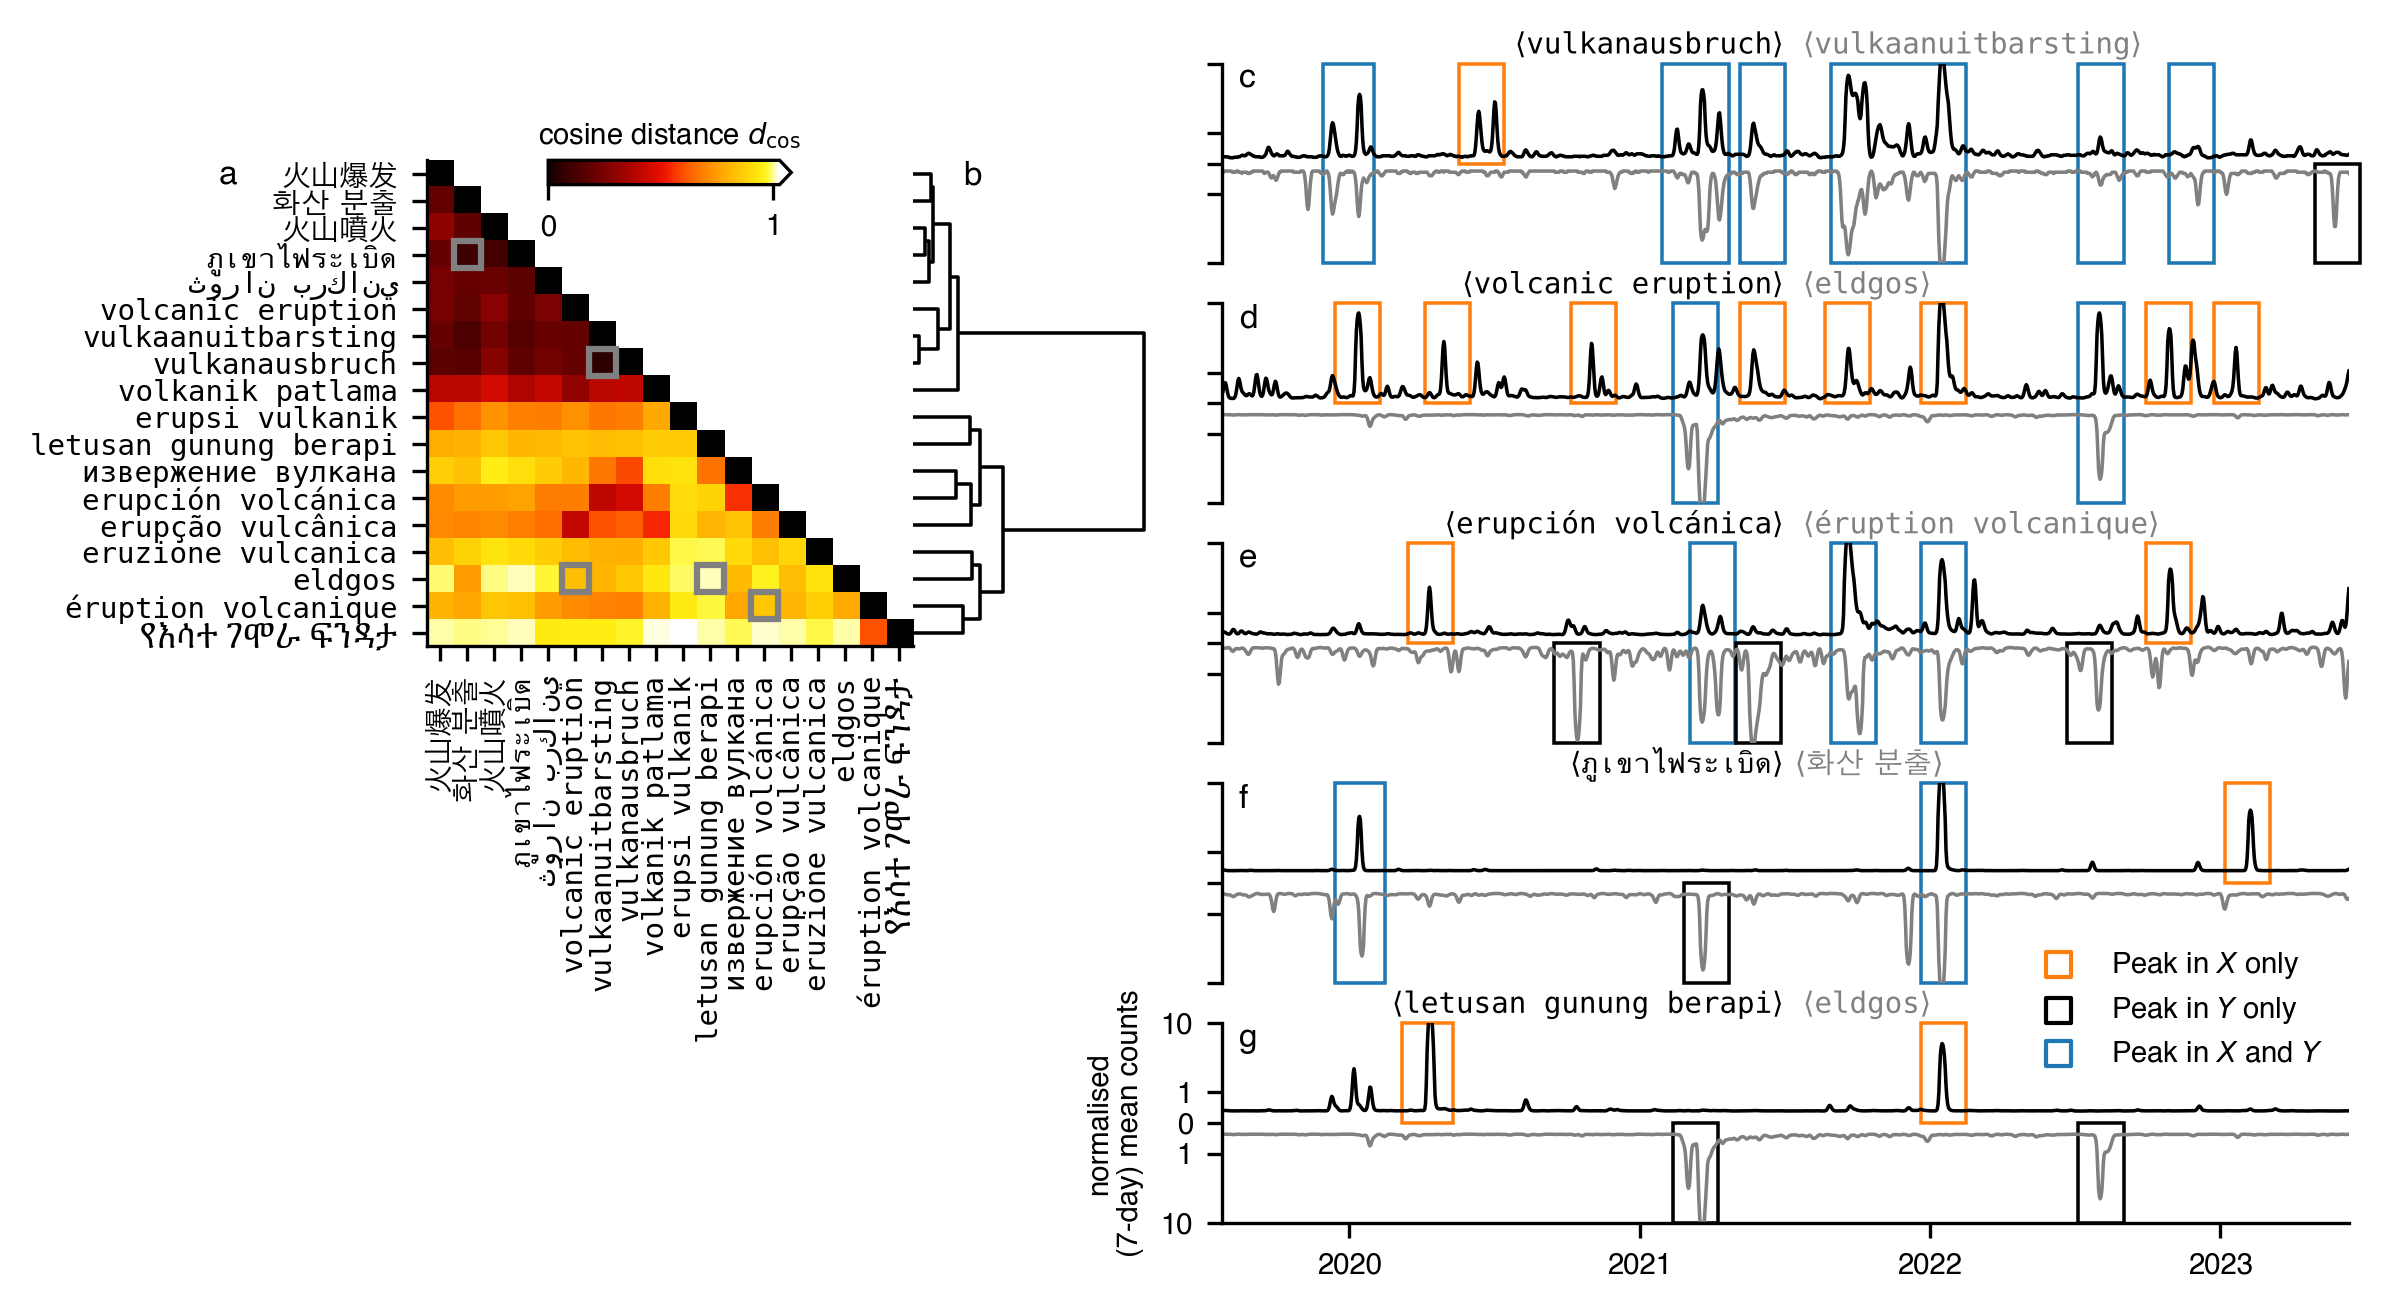

In [31]:
fig = plt.figure(1, figsize = mm2inch(210,130), dpi = 300)

ax = plt.subplot2grid((5, 5), (0, 0), colspan=2, rowspan=3)
ax.annotate("a", (0, 1),xytext=(-50, 0),
                      xycoords='axes fraction',textcoords='offset points',
    color='k',fontsize = 8, weight='bold',
                ha='left', va='top', zorder = 1000)
ax.annotate("b", (1, 1),xytext=(12, 0),
                      xycoords='axes fraction',textcoords='offset points',
    color='k',fontsize = 8, weight='bold',
                ha='left', va='top', zorder = 1000)

heatmap = ax.imshow(D, aspect="equal", cmap=cmap)

# ticks and labels
new_tick_labels = [abbr2string(st).lower() for st in B.columns]
plt.xticks(ticks=np.arange(len(new_tick_labels)), labels=new_tick_labels, rotation=90)
plt.yticks(ticks=np.arange(len(new_tick_labels)), labels=new_tick_labels, rotation=0)

# adjust font for language
for tick_label, tick_text in zip(plt.gca().get_xticklabels(), B.columns):
    lan = cld3.get_language(tick_text)[0]
    tick_label.set_fontname(alt_font(lan))
for tick_label, tick_text in zip(plt.gca().get_yticklabels(), B.index):
    lan = cld3.get_language(tick_text)[0]
    tick_label.set_fontname(alt_font(lan))

# もve colorbar into the heatmap


cax = inset_axes(ax, width="50%", height="5%", loc="upper center", borderpad=0)
cbar = fig.colorbar(heatmap, cax=cax, orientation="horizontal", extend="max")
cbar.set_label("cosine distance $d_{\cos}$")
cbar.ax.xaxis.set_label_position('top')

# separate dendrogram subplot
divider = make_axes_locatable(ax)
row_ax = divider.append_axes("right", size="50%", pad=0)
dendrogram(linkage_matrix_opt, no_labels=True, orientation="right", 
           ax=row_ax, color_threshold=0, above_threshold_color="black")
plt.setp(row_ax.collections,linewidth=.85)

row_ax.axis("off")
row_ax.invert_yaxis()

ax.spines["top"].set_visible(False) 
ax.spines["right"].set_visible(False)

ax1 = plt.subplot2grid((5, 5), (0, 2), colspan=3, rowspan=1)
ax2 = plt.subplot2grid((5, 5), (1, 2), colspan=3, rowspan=1)
ax3 = plt.subplot2grid((5, 5), (2, 2), colspan=3, rowspan=1)
ax4 = plt.subplot2grid((5, 5), (3, 2), colspan=3, rowspan=1)
ax5 = plt.subplot2grid((5, 5), (4, 2), colspan=3, rowspan=1)


pixels = [(7,6), (15,5), (16,12), (3,1), (15,10)]
for row, col in pixels:
    patch = patches.Rectangle(
        (col - 0.5, row - 0.5),  # lower-left corner
        1, 1,  # width, height
        linewidth=1.5,
        edgecolor="grey",#'#1f77b4',  # Border color
        facecolor='none',  # No fill
        transform=ax.transData
    )
    ax.add_patch(patch)

pairs = [("vulkanausbruch","vulkaanuitbarsting" ),("volcanic", "eldgos"),
         ("erupción","éruption"),("ภูเขาไฟระเบิด","화산"),("letusan", "eldgos")]

for ix, ax in enumerate([ax1, ax2, ax3, ax4, ax5]):# ax5, ax6]):
    s1 = pairs[ix][0]
    s2 = pairs[ix][1]
    
    ax.annotate(STRING.ascii_lowercase[ix+2], (0, 1),xytext=(4, 0),
                      xycoords='axes fraction',textcoords='offset points',
    color='k',fontsize = 8, weight='bold',#path_effects = buffer,
                ha='left', va='top', zorder = 1000)


    ax.plot(tweet_counts_df_normalised[s1] + 0.5, color="k", lw=0.85)
    ax.plot(tweet_counts_df_normalised[s2] * -1 - 0.5, color="grey", lw=0.85)

    ax.set_yscale('symlog')
    lan1 = cld3.get_language(s1)[0]
    lan2 = cld3.get_language(s2)[0]
    for sp in ["top", "bottom", "right"]:
        ax.spines[sp].set_visible(False)
    ax.annotate(r"$\langle${}$\rangle$ ".format(abbr2string(s1).lower()), xy=(.5,1.05),
                xycoords="axes fraction", ha="right",
            fontname=alt_font(lan1), zorder=1000, path_effects=buffer)
    ax.annotate(r" $\langle${}$\rangle$".format(abbr2string(s2).lower()), xy=(.5,1.05),
                xycoords="axes fraction", ha="left", color="grey",
                fontname=alt_font(lan2), zorder=1000, path_effects=buffer)

       
    ax.set_xlabel("")
    ax.set_xticklabels("")
    ax.set_xlim(min(common_index),max(common_index))
    ax.set_ylim(-10,10)
    ax.set_xticks([])
    if not ax == ax5:
        ax.set_yticklabels("")




# patch parameters for each axis
patch_data = {
    ax1: [
        ((0.09, 0), (0.045, 1), '#1f77b4'),
        ((0.39, 0), (0.06, 1), '#1f77b4'),
        ((0.46, 0), (0.04, 1), '#1f77b4'),
        ((0.21, 0.5), (0.04, 0.5), '#ff7f0e'),
        ((0.97, 0), (0.04, 0.5), 'k'),
        ((0.54, 0), (0.12, 1), '#1f77b4'),
        ((0.76, 0), (0.04, 1), '#1f77b4'),
        ((0.84, 0), (0.04, 1), '#1f77b4')
    ],
    ax2: [
        ((0.4, 0), (0.04, 1), '#1f77b4'),
        ((0.1, 0.5), (0.04, 0.5), '#ff7f0e'),
        ((0.62, 0.5), (0.04, 0.5), '#ff7f0e'),
        ((0.18, 0.5), (0.04, 0.5), '#ff7f0e'),
        ((0.31, 0.5), (0.04, 0.5), '#ff7f0e'),
        ((0.46, 0.5), (0.04, 0.5), '#ff7f0e'),
        ((0.535, 0.5), (0.04, 0.5), '#ff7f0e'),
        ((0.82, 0.5), (0.04, 0.5), '#ff7f0e'),
        ((0.88, 0.5), (0.04, 0.5), '#ff7f0e'),
        ((0.76, 0), (0.04, 1), '#1f77b4')
    ],
    ax3: [
        ((0.415, 0), (0.04,1), '#1f77b4'),
        ((0.165, 0.5), (0.04, 0.5), '#ff7f0e'),
        ((0.82, 0.5), (0.04, 0.5), '#ff7f0e'),
        ((0.295, 0), (0.04, 0.5), 'k'),
        ((0.456, 0), (0.04, 0.5), 'k'),
        ((0.75, 0), (0.04, 0.5), 'k'),
        ((0.54, 0), (0.04, 1), '#1f77b4'),
        ((0.62, 0), (0.04, 1), '#1f77b4')
    ],
    ax4: [
        ((0.1, 0), (0.045, 1), '#1f77b4'),
        ((0.89, 0.5), (0.04, 0.5), '#ff7f0e'),
        ((0.41, 0), (0.04, 0.5), 'k'),
        ((0.62, 0), (0.04, 1), '#1f77b4')
    ],
    ax5: [
        ((0.16, 0.5), (0.045, 0.5), '#ff7f0e'),
        ((0.62, 0.5), (0.04, 0.5), '#ff7f0e'),
        ((0.76, 0), (0.04, 0.5), 'k'),
        ((0.4, 0), (0.04, 0.5), 'k')
    ]
}

# add patches dynamically
for ax, params in patch_data.items():
    for position, size, color in params:
        add_patch(ax, position, size, color)
plt.gca().yaxis.set_major_formatter(FuncFormatter(positive_tick_formatter))

ax5.scatter([],[], marker="s", c="None", ec="#ff7f0e", label=r"Peak in $X$ only")
ax5.scatter([],[], marker="s", c="None", ec="k", label=r"Peak in $Y$ only")
ax5.scatter([],[], marker="s", c="None", ec="#1f77b4", label=r"Peak in $X$ and $Y$")
ax5.legend(fancybox = "None",edgecolor="None",loc='upper right', bbox_to_anchor=(1, 1.5))
ax5.set_ylabel("normalised\n(7-day) mean counts")
locator = mdates.AutoDateLocator(minticks=3, maxticks=6)
formatter = mdates.ConciseDateFormatter(locator)
ax5.xaxis.set_major_locator(locator)
ax5.xaxis.set_major_formatter(formatter)
ax5.spines["bottom"].set_visible(True)


plt.savefig("Figures/Figure4.svg", bbox_inches="tight")
plt.savefig("Figures/Figure4.png", bbox_inches="tight")

### All pairwise combinations (153 pairs) of timeseries comparisons (mirror plots)

火山噴火  |  vulkaanuitbarsting


AttributeError: module 'matplotlib.pyplot' has no attribute 'sa'

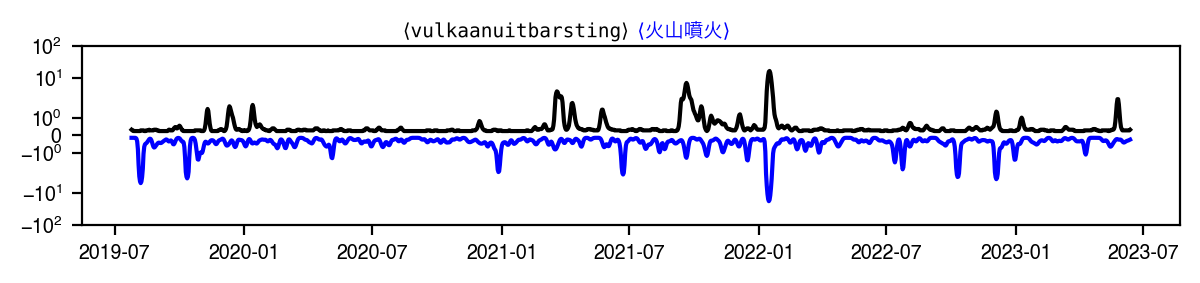

In [32]:
for (s1, s2) in combinations(tweet_counts_df_normalised.columns, 2):
    print(s2," | ", s1)
    fig = plt.figure(1, figsize = mm2inch(180,30), dpi = 200)
    plt.plot(tweet_counts_df_normalised[s1]+.5, color="k")
    plt.plot(tweet_counts_df_normalised[s2]*-1-.5, color="blue")

    lan1 = cld3.get_language(s1)[0]
    lan2 = cld3.get_language(s2)[0]
   
    plt.annotate(r"$\langle${}$\rangle$ ".format(abbr2string(s1).lower()), xy=(.5,1.05),
                xycoords="axes fraction", ha="right",
            fontname=alt_font(lan1), zorder=1000, path_effects=buffer)
    plt.annotate(r" $\langle${}$\rangle$".format(abbr2string(s2).lower()), xy=(.5,1.05),
                xycoords="axes fraction", ha="left", color="blue",
                fontname=alt_font(lan2), zorder=1000, path_effects=buffer)
    plt.yscale('symlog')
    plt.ylim(-100,100)
    plt.sa
    plt.show()